                                      **PROJET BIG DATA**

                                      **SAHI Kenza | HAMEL Amir**

#Importation des packages

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from numpy import sqrt, square, pi, exp, zeros, linspace
from copy  import deepcopy
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi
from statistics import mean


In [ ]:
! pip install -q apache-beam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 41.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 11.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.0/152.0 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 40.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 677.1/677.1 kB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 45.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.4/300.4 kB 27.4 MB

In [ ]:
import apache_beam as beam
from apache_beam.transforms.userstate import BagStateSpec

In [ ]:
def eval_clustering_2D(X, full_points, labels):
  plt.figure(figsize = (6, 4))
  plt.title("Clusters")
  plt.scatter(x = full_points[:, 0], y = full_points[:, 1], color="grey")
  plt.scatter(x = X[:, 0], y = X[:, 1], c = labels)
  plt.show()

#Partie A : Implémentation de k-means séquentiel

Le but de cette première partie est d'implémenter une version séquentielle de l'algorithme Kmeans.

Dans un premier temps nous génèrons un jeu de données consistant en des points répartis en deux classes. Nous avons généré une première classe de 100 points répartis à
proximité d’un centroïde de coordonnées (5, 5) et une autre classe où 100 points sont autour des coordonnées (10, 10). Nous avons ensuite enregistré ces données dans un fichier CSV que nous réutiliserons par la suite pour tester notre implémentation.

## Génération et visualisation des données

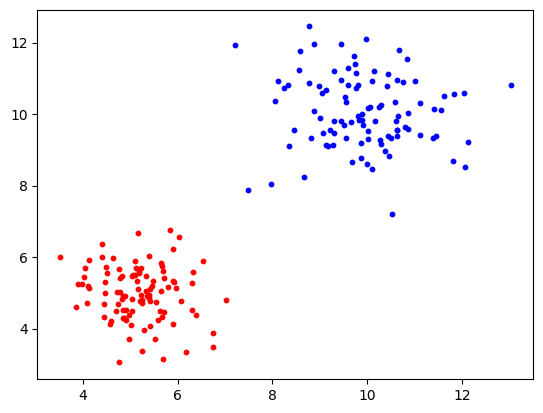

In [ ]:
centers = [(5, 5), (10, 10)]
cluster_std = [0.8, 1]
X,y = make_blobs(n_samples=200, cluster_std=cluster_std, centers=centers, random_state=1)
plt.scatter(X[y == 0, 0], X[y == 0, 1], color="red", s=10, label="Cluster1")
plt.scatter(X[y == 1, 0], X[y == 1, 1], color="blue", s=10, label="Cluster2")

##La taille de notre dataset généré

In [ ]:
X.shape

(200, 2)

In [ ]:
Dataset = pd.DataFrame(X)

##Arrondissement des valeurs des coordonnées des points générés

In [ ]:
Dataset=Dataset.round(decimals = 2)

##Stocker le dataset généré dans un fichier sous format csv

Enregistrer les données dans un fichier csv

In [ ]:
# Enregistrer les données dans un csv
np.savetxt('data.csv', Dataset, delimiter=',', header="att1,att2")

Pour lire des données en consommant peu de mémoire, On va utiliser le bibliothèqu Pandas avec la fonction "read_csv()" qui peut lire un fichier CSV en plusieurs chunks et les traiter en parallèle pour économiser de la mémoire, ainsi qu'on va determiner aussi le type de chaque colonne

In [ ]:
df= pd.read_csv("/content/data.csv")

In [ ]:
df.head()

,# att1,att2
0,5.67,5.74
1,9.96,12.11
2,10.49,9.32
3,10.13,11.20
4,8.06,10.35


## Implémentation du K-means sequentiel

Dans ce qui suit, nous avons l'implémentation en Python du Kmeans séquentiel.

In [ ]:
def sequential_kmeans(X, k):

  cluster = np.zeros(X.shape[0])
  centroids = X.sample(k).values
  n=np.zeros(k)
  # for each new observation
  for i, row in enumerate(X.values):
      mn_dist = float('inf')
    # dist of the point from centroids
      for idx, centroid in enumerate(centroids):
          d = np.sqrt((centroid[0]-row[0])**2 + (centroid[1]-row[1])**2)
          # store closest centroid
          if mn_dist > d:
              mn_dist = d
              cluster[i] = idx
              id=idx
      # number of points in cluster i
      n[id]=n[id]+1
      new_centroid=[]
      for (a,b) in zip(centroids[id],row):
        new_centroid=[a+(b-a)/n[id]]
      centroids[id]=new_centroid
  return centroids,cluster

In [ ]:
km=sequential_kmeans(df,2)

Le code fourni met en œuvre l'algorithme séquentiel k-means, qui procède par l'ajustement progressif des centres des clusters. À chaque itération, l'algorithme attribue chaque point de données au centre le plus proche, puis il met à jour la position de ce centre en fonction de la moyenne des points qui lui ont été assignés. Cette méthode permet aux centres de s'adapter dynamiquement, reflétant la distribution sous-jacente des données.

##Plot Clustering results

Afin d'évaluer les résultats de clustering obtenus en utilisant l'implémentation séqentielle du kmeans, nous avons affichés les nuages de points des deux clusters obtenus. Nous voyons qu'il n'y a qu'un seul point qui a été mal classé.



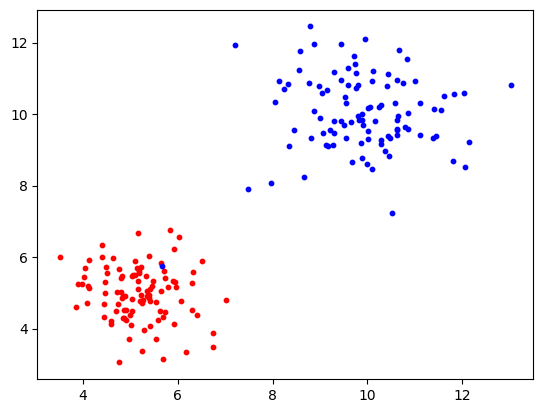

In [ ]:
plt.scatter(df.values[km[1] == 0, 0], df.values[km[1] == 0, 1], color="red", s=10, label="Cluster1")
plt.scatter(df.values[km[1] == 1, 0], df.values[km[1] == 1, 1], color="blue", s=10, label="Cluster2")

##Les coordonnées des centres des deux clusters

In [ ]:
centroids =km[0]
centroids

array([[ 4.98141414,  4.98141414],
       [10.02247525, 10.02247525]])

Après avoir exécuté l'algorithme pour une seule époque, les résultats montrent que les centres des clusters ont convergé vers des valeurs qui reflètent étroitement les centroïdes autour desquels les données ont été initialement simulées :

Centre du premier cluster : (4.98, 4.98)
Centre du deuxième cluster : (10.022, 10.022)
Ces résultats sont cohérents avec nos attentes, étant donné les centroïdes théoriques de (5, 5) et (10, 10). L'approximation précise des positions des centres indique une bonne performance de l'algorithme et une adaptation correcte aux caractéristiques de notre jeu de données.

##Les étiquettes des 200 points obtenus

In [ ]:
cluster = km[1]
cluster

array([1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1.,
       1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0.,
       0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0.,
       1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0.,
       1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1.,
       1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0.])

##Calcul du NMI pour mesurer la qualité du clustering

Nous pouvons également nous assurer des partitions obtenues en observant la métrique NMI égale à 96%

In [ ]:
print("Normalized Mutual Information:", nmi(y,km[1]))

Normalized Mutual Information: 0.9595659056988861


#Partie B : Implémentation d’une version streaming de k-means

Dans ce qui suit, on implémente une version streaming de l'algorithme Kmeans.
L'algorithme streaming de k-means adapté tient compte de la pondération des données en fonction de leur ancienneté dans le flux. Les points de données plus anciens ont moins d'influence sur la position des centres des clusters, permettant à l'algorithme de s'adapter plus rapidement aux changements de données (concept drift).

Algorithme :

Si la taille de X est T : enlever le plus vieux batch de X
Ajouter B⁰ à X

Initialiser les centroïdes C avec la partition P

Obtenir les centroïdes C et la partition P avec l’algorithme k-means pondéré :

les points des batches sont pondérés par rt où t est le numéro du batch ordonné
 par ordre décroissant : 0 est le batch le plus récent, 1 est le batch
précédent, etc.

In [ ]:
T = 5 #max number of batches to keep
r = 0.8 #weigting parameter to set how important history is
k = 2
BATCH_SIZE = 50
FEATURE_SIZE = 2
batch_weighting = [r**i for i in range(T-1, -1, -1)] # inverse order
# X list of batches
# P the centroids for the batches in the form (k, FEATURE_SIZE)

def streaming_kmeans(X, P, B0):
  if len(X) == T:
     X = X[1:] #remove first (older) batch
  X.append(B0)

  input_values_dims = (BATCH_SIZE * len(X), FEATURE_SIZE)
  weights = []
  X_concatenated = None
  for i, batch in enumerate(X):
    #add same weighting for all element in bach
    current_batch_weights = [batch_weighting[i]] * batch.shape[0]
    weights.extend(current_batch_weights)

    if X_concatenated is None:
      X_concatenated = batch
    else :
       X_concatenated = np.concatenate((X_concatenated, batch))

  kmeans = KMeans(n_clusters=k, init=P, random_state=42, n_init=1).fit(X_concatenated, sample_weight=weights)
  centroids = kmeans.cluster_centers_
  partition = kmeans.labels_

  return [centroids, partition, X_concatenated]


Cette fonction streaming_kmeans utilise une liste de tuples pour gérer l'historique des lots avec leur âge.

In [ ]:
batch_weighting

[0.4096000000000001, 0.5120000000000001, 0.6400000000000001, 0.8, 1.0]

On génère un dataset avec 2 clusters

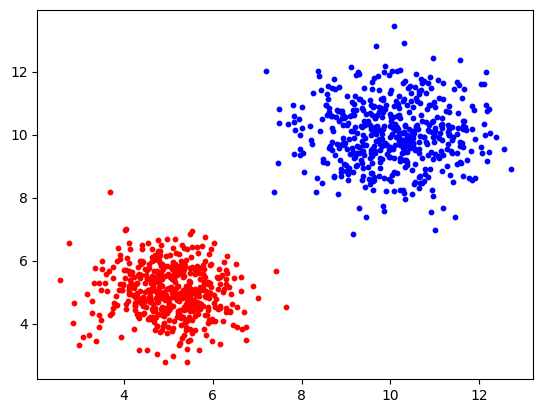

In [ ]:
centers = [(5, 5), (10, 10)]
cluster_std = [0.8, 1]

X,y = make_blobs(n_samples=1000, cluster_std=cluster_std, centers=centers, random_state=1)

plt.scatter(X[y == 0, 0], X[y == 0, 1], color="red", s=10, label="Cluster1")
plt.scatter(X[y == 1, 0], X[y == 1, 1], color="blue", s=10, label="Cluster2")

Les 1000 points sont divisés en 20 batchs.

In [ ]:
batches = np.split(X, 20)
print(len(batches))
print(batches[0].shape)

20
(50, 2)


In [ ]:
# initialize centroids as random points of X
centroids_idx = np.random.choice(X.shape[0], k)
centroids = X[centroids_idx, ]
centroids

array([[10.98857808,  9.75717358],
       [10.14936996, 10.58208739]])

Iteration  0


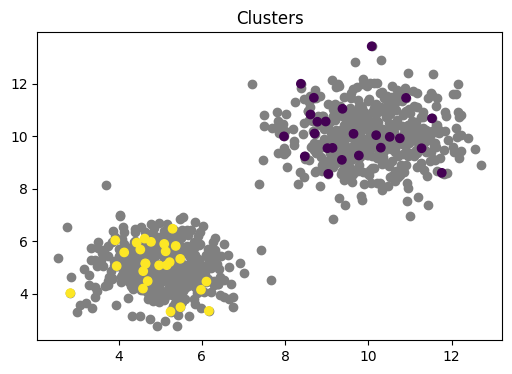

Iteration  4


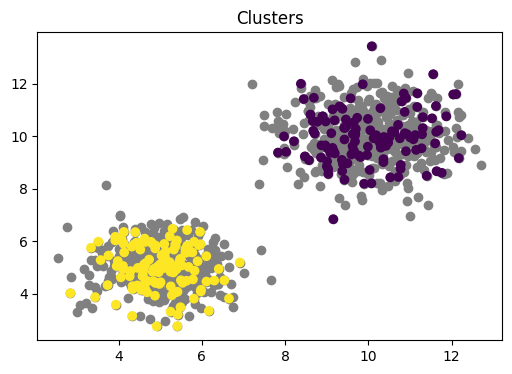

Iteration  8


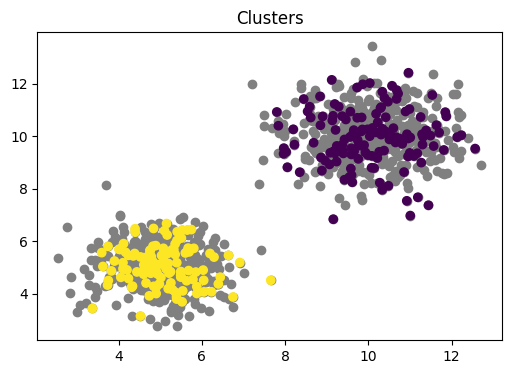

Iteration  12


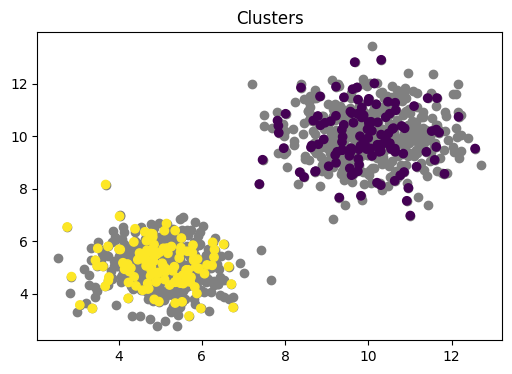

Iteration  16


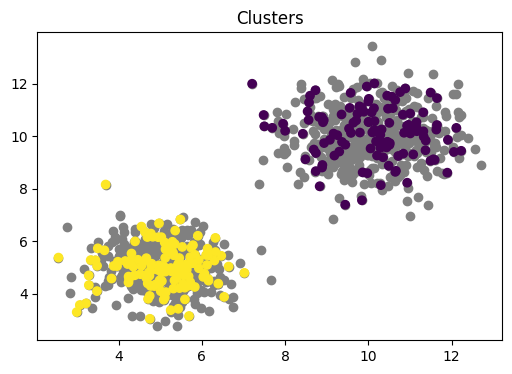

In [ ]:
old_batches = []
for i in range(20):
  oldest_index = max(0, i-5)
  previous_batches = batches[oldest_index:i]
  res = streaming_kmeans(previous_batches, centroids, batches[i])
  centroids = res[0]
  new_partition = res[1]
  if i % 4 == 0:
    print("Iteration ", i)
    # the whole data is displayed as grey points
    # colored points are the partition returned by streaming_kmeans for the current batches
    eval_clustering_2D(res[2], X, new_partition)

Les résultats montrent une série de lots de données  où l'on peut observer un léger déplacement des points de données au fil du temps, suggérant une évolution ou un concept drift dans les données. La dernière image représente à la fois le lot initial et le dernier lot avec les centres initiaux et mis à jour. Les centroïdes mis à jour semblent avoir légèrement bougé par rapport aux centres initiaux, ce qui indique que l'algorithme de k-means en streaming a ajusté les centres des clusters pour s'adapter à la nouvelle distribution des données. Cela illustre l'objectif de l'algorithme streaming k-means, qui est d'adapter les clusters au fur et à mesure que de nouvelles données arrivent, en tenant compte de la dérive dans l'espace des caractéristiques.

On génère un nouveau dataset avec une distribution qui change au cours du temps. La seconde moitié des données a des centroides différents.

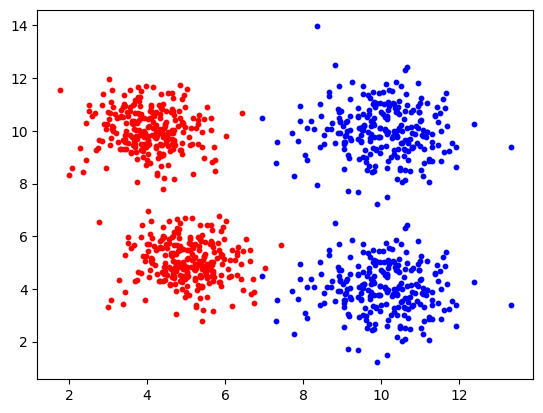

In [ ]:
centers = [(5, 5), (10, 10)]
cluster_std = [0.8, 1]

X,y = make_blobs(n_samples=500, cluster_std=cluster_std, centers=centers, random_state=1)

new_centers = [(4, 10), (10, 4)]

X2,y2 = make_blobs(n_samples=500, cluster_std=cluster_std, centers=new_centers, random_state=1)

X_tot = np.concatenate((X, X2))
y_tot = np.concatenate((y, y2))

plt.scatter(X_tot[y_tot == 0, 0], X_tot[y_tot == 0, 1], color="red", s=10, label="Cluster1")
plt.scatter(X_tot[y_tot == 1, 0], X_tot[y_tot == 1, 1], color="blue", s=10, label="Cluster2")

In [ ]:
batches = np.split(X_tot, 20)
print(len(batches))
print(batches[0].shape)

20
(50, 2)


In [ ]:
# initialize centroids as random points of X
centroids_idx = np.random.choice(X_tot.shape[0], k)
centroids = X_tot[centroids_idx, ]
centroids

array([[5.12501108, 4.84782318],
       [4.0406462 , 9.49040348]])

Iteration  0


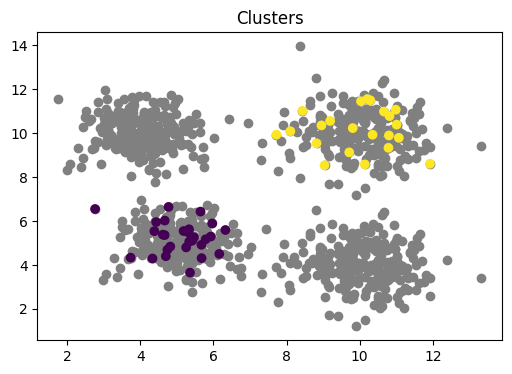

Iteration  2


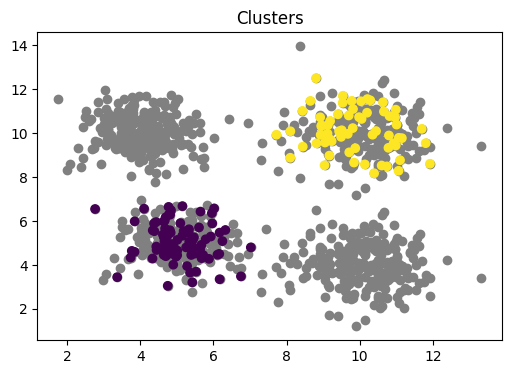

Iteration  4


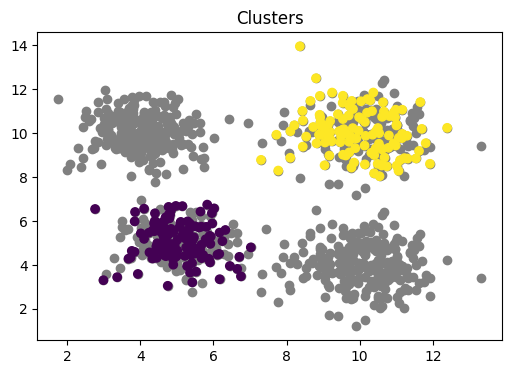

Iteration  6


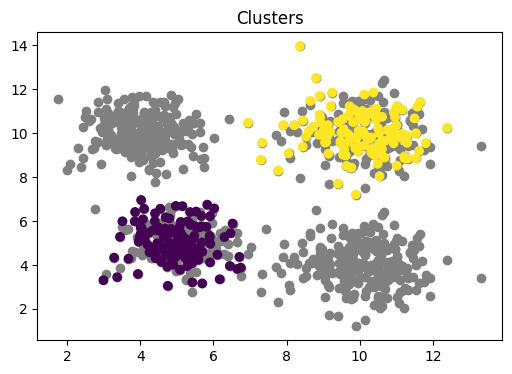

Iteration  8


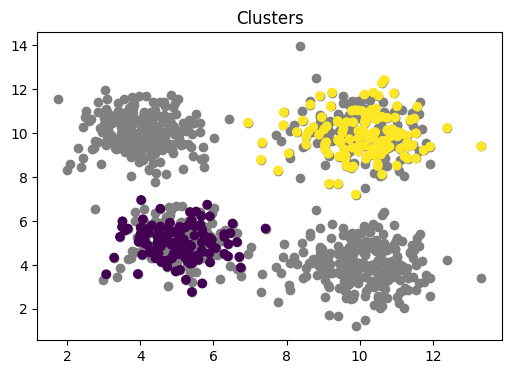

Iteration  10


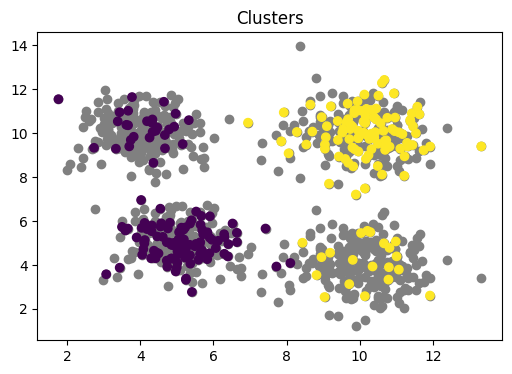

Iteration  12


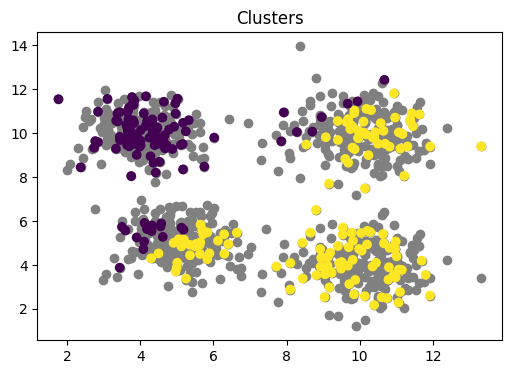

Iteration  14


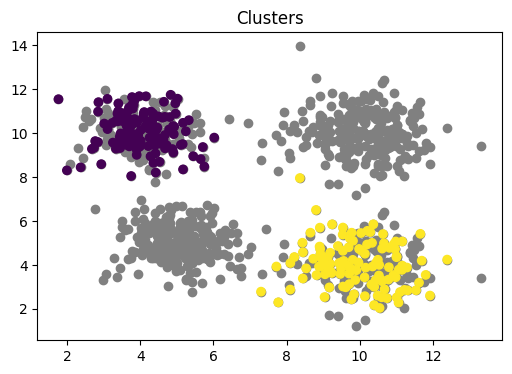

Iteration  16


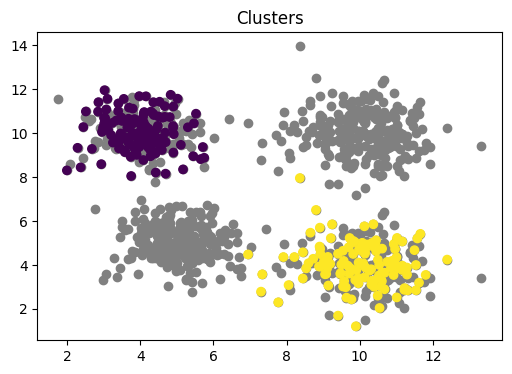

Iteration  18


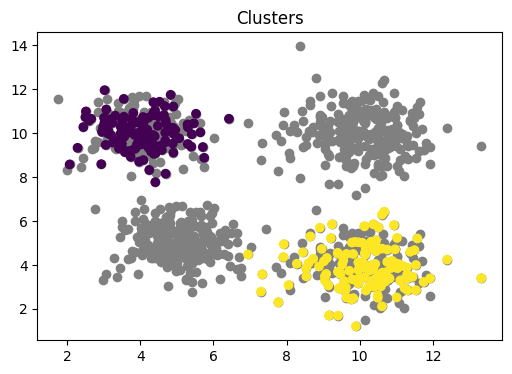

In [ ]:
old_batches = []
r = 0.7
batch_weighting = [r**i for i in range(T-1, -1, -1)]

for i in range(20):

  oldest_index = max(0, i-5)
  previous_batches = batches[oldest_index:i]
  res = streaming_kmeans(previous_batches, centroids, batches[i])
  centroids = res[0]
  new_partition = res[1]
  if i % 2 == 0:
    print("Iteration ", i)
    # the whole data is displayed as grey points
    # colored points are the partition returned by streaming_kmeans for the current batches
    eval_clustering_2D(res[2], X_tot, new_partition)

L'algorithme s'adapte à la nouvelle distribution avec une période de transition visible à l'itération 12.

Si nous fixons la valeur de r à 1, cela signifiera que le passé aura une influence équivalente au présent, ce qui ralentira le processus de changement des centroïdes, notamment lors des périodes cruciales où des points proviennent à la fois de l'ancienne et de la nouvelle distribution (par exemple, les itérations 10, 11, 12).

Iteration  0


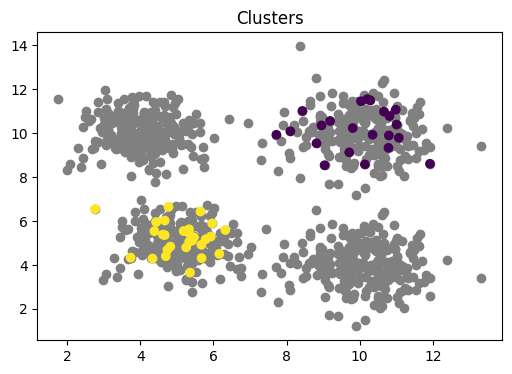

Iteration  2


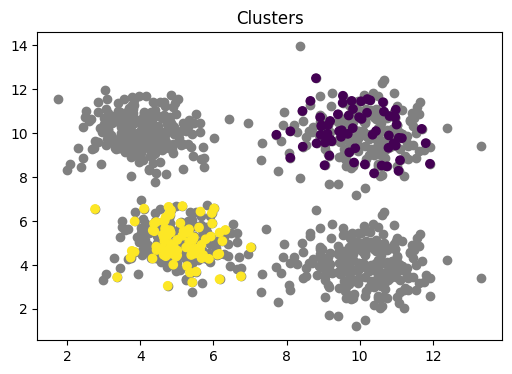

Iteration  4


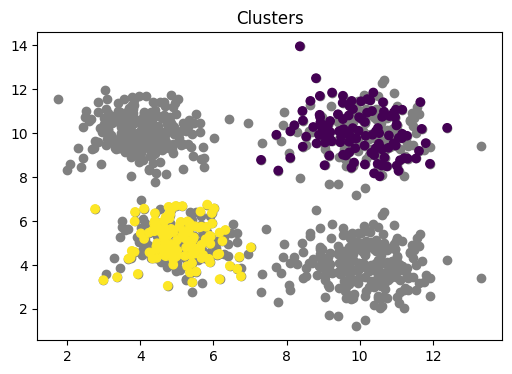

Iteration  6


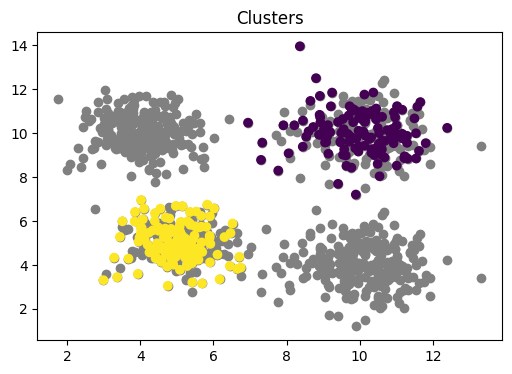

Iteration  8


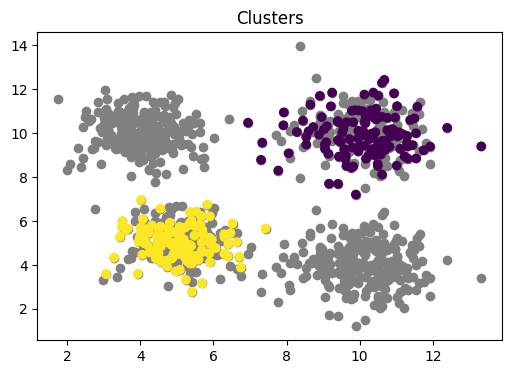

Iteration  10


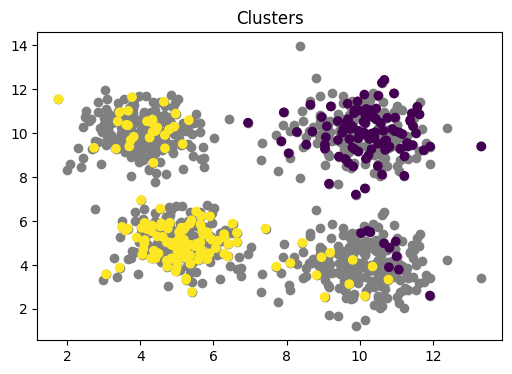

Iteration  12


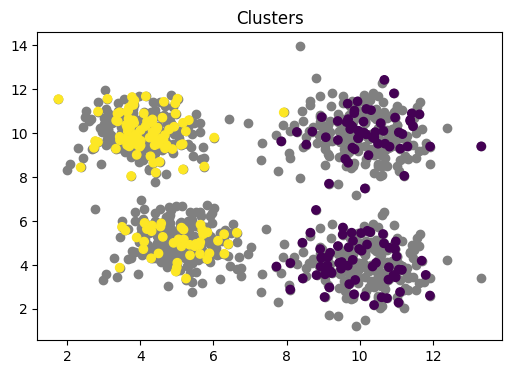

Iteration  14


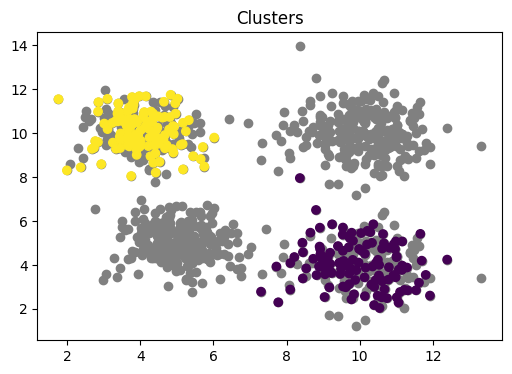

Iteration  16


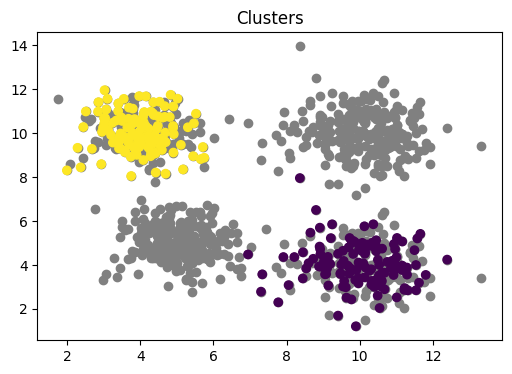

Iteration  18


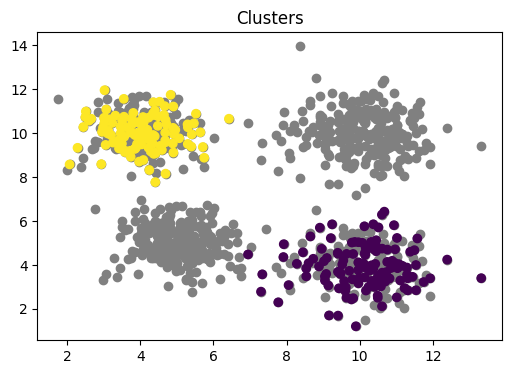

In [ ]:
r = 1
batch_weighting = [r**i for i in range(T-1, -1, -1)]

centroids_idx = np.random.choice(X_tot.shape[0], k)
centroids = X_tot[centroids_idx, ]
old_batches = []

for i in range(20):

  oldest_index = max(0, i-5)
  previous_batches = batches[oldest_index:i]
  res = streaming_kmeans(previous_batches, centroids, batches[i])
  centroids = res[0]
  new_partition = res[1]
  if i % 2 == 0:
    print("Iteration ", i)
    # the whole data is displayed as grey points
    # colored points are the partition returned by streaming_kmeans for the current batches
    eval_clustering_2D(res[2], X_tot, new_partition)

Comme anticipé, à la 12e itération, on observe que le clustering continue de s'équilibrer entre les deux distributions lorsque r=1. En revanche, avec une valeur de r plus faible, la transition vers la nouvelle distribution était déjà nettement marquée.

Nous sommes satisfaits de constater dans les résultats de la cellule précédente que les clusters ont été correctement identifiés : les valeurs proches de 5 ont été assignées au cluster 2, tandis que celles proches de 10 ont été attribuées au cluster 1. Cependant, deux points méritent d'être soulignés :

1. Le jeu de données utilisé ici est caricatural, avec des points naturellement bien séparés , sans présence d'outliers, et une seule itération de l'algorithme du k-means a été suffisante. Pour des cas plus complexes, il pourrait être nécessaire d'exécuter l'algorithme plusieurs fois.

2. Lors de la conversion en dictionnaire de la collection des centroïdes, nous avons supposé que toutes les données de la collection tiennent en mémoire. Dans ce cas particulier avec seulement deux classes, cette supposition est évidemment valide. Cependant, si la situation devenait plus complexe, il pourrait être envisageable de procéder par morceaux (chunks), puis, à partir des moyennes obtenues, calculer une seule moyenne englobant l'ensemble des points.

#Partie C : Implémentation de k-means distribué (Apache Beam)

Pour cette partie, on implémente une version distribuée de l'algorithme Kmeans en utilisant Apache Beam.

On se place dans un premier temps dans le cas de données en dimension 1 (une seule coordonnée par point).

In [ ]:
a = np.random.rand(200)

In [ ]:
def create_tuples(text):
  clusters=[0,1]

  t = (int(np.random.choice(clusters)),text)
  return  t
output = []
def collect(row):
    output.append(row)
    return True
def calcul_centroid(elt):
  c=[]

  for e in elt:
    c.append(e[1])
  return (elt[0][0], mean(c))

En premier lieu, nous avons instauré la Pcollection 'lines', contenant l'ensemble des points, et lui avons appliqué une transformation qui attribue à chaque point un cluster sous forme de tuple.

En second lieu, la Pcollection 'centroids' a été créée, calculant les coordonnées des centroides pour chaque cluster sous forme de tuple à partir du résultat de la Pcollection précédente, en appliquant une série de transformations.

Par la suite, nous avons mis en œuvre l'étape de partitionnement en créant la fonction 'assign_cluster', que nous avons utilisée pour assigner à chaque point un numéro de cluster, enregistré dans la PCollection 'partition'. Nous avons supposé que les centroides pouvaient être représentés sous forme de dictionnaire, en considérant que chaque élément de 'centroids' étant un tuple, le premier terme est la clé et le second la valeur.

En conclusion, en sortie, nous obtenons un tuple comprenant le numéro du cluster et les coordonnées du point.

In [ ]:
def assign_cluster(coord, centroids):
  mn_dist = float('inf')
  for key,value in centroids.items():
    d = np.sqrt((value-coord)**2 )
    if mn_dist > d:
      mn_dist = d
      id=key
  return (id,coord)

In [ ]:
with beam.Pipeline() as pipeline:
  lines = (
      pipeline
      | 'lines' >> beam.Create(a)
      |'create tuples' >> beam.Map(create_tuples)
      | "print" >> beam.Map(collect))

  centroids = (pipeline | 'Centroidss' >> beam.Create(output)
      | beam.GroupBy(lambda s: s[0])
      | "take one" >> beam.Map(lambda s: s[1])
      | "count mean" >> beam.Map(calcul_centroid))

  partition = (
      pipeline
      | 'Partition' >> beam.Create(a)
      | 'Assign cluster' >> beam.Map(
          assign_cluster,
          centroids=beam.pvalue.AsDict(centroids),
      )
      | beam.Map(print))

(0, 0.0036183792263072556)
(1, 0.8708940715484462)
(0, 0.09684552561297677)
(0, 0.08670620758117953)
(0, 0.3517674524497397)
(1, 0.6270039309706011)
(1, 0.9730149132919075)
(0, 0.44331052678488747)
(0, 0.4655853638579406)
(0, 0.38793319444584173)
(0, 0.17284684560076358)
(0, 0.455682962205183)
(0, 0.1997364303347442)
(0, 0.2638309407803069)
(0, 0.4093864080132359)
(1, 0.6105406642942993)
(1, 0.8377801687660891)
(0, 0.33740085415893084)
(1, 0.9811891443910933)
(1, 0.8746956548996576)
(0, 0.4774981266813102)
(0, 0.007099314549005475)
(0, 0.26351797362389684)
(1, 0.5534153497681505)
(0, 0.25763420224245237)
(0, 0.30617824276858274)
(0, 0.07859348239463448)
(1, 0.8890312746893132)
(0, 0.11456661589224648)
(1, 0.8767236272712472)
(1, 0.737402517954051)
(0, 0.02116943419771322)
(1, 0.7623882085964826)
(1, 0.6213696035133982)
(0, 0.04288553299484732)
(0, 0.10742050821659721)
(1, 0.5716372774567618)
(1, 0.9349310147354748)
(1, 0.9075150518020524)
(0, 0.10187107798954864)
(1, 0.7621392320227595

# Partie D: Implémentation de k-means séquentiel distribuée (Apache Beam)

Dans cette section, nous mettons en œuvre l'algorithme décrit dans la partie A à l'aide d'Apache Beam.

Tout d'abord, nous créons notre ensemble de données, puis nous sélectionnons aléatoirement un centre pour chaque classe. Ensuite, nous assignons notre ensemble de données à une PCollection à laquelle nous appliquons une transformation. Cette transformation assigne chaque nouveau point au cluster le plus proche, met à jour le centroïde et l'effectif de la classe affectée, puis nous renvoie le numéro de la classe.

In [ ]:
X=np.concatenate([ np.random.uniform(5, 1, size=(100, 2)) , np.random.uniform(20, 1, size=(100, 2))])
k=2
centroid_rand = []
l = list(range(1,len(X)))
for i in range(k):
  index = np.random.choice(l)
  centroid_rand.append(X[index])
centroids = np.array(centroid_rand)

def calcul_cluster_proche(point,centroids):
  mn_dist = float('inf')
    # dist of the point from centroids
  for idx, centroid in enumerate(centroids):
      d = np.sqrt((centroid[0]-point[0])**2 + (centroid[1]-point[1])**2)
        # store closest centroid
      if mn_dist > d:
        mn_dist = d
        closest_cluster = idx
  return closest_cluster

class Kmeans_sequentiel_dist(beam.DoFn):
  def _init_(self,centroids=centroids):
    self.centroids = centroids
    counts = [0,0]
  def process(self, element):

    counts  = np.zeros((2))
    point = element
    allocated_cluster = calcul_cluster_proche(point, centroids)
    for t in range(2):
      centroids[allocated_cluster,t] += (point[t] - centroids[allocated_cluster,t])/(counts[allocated_cluster]+1)
    counts[allocated_cluster] += 1
    yield allocated_cluster
with beam.Pipeline() as pipeline:
  data = (
      pipeline
      | "Create" >> beam.Create(X)
  )
  (data
  | "Update_state" >> beam.ParDo(Kmeans_sequentiel_dist())
  | 'Print' >> beam.Map(print)
  )

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
0
1
0
1
0
1
1
1
0
0
0
1
0
1
1
0
1
0
0
1
1
0
0
0
0
0
1
0
1
0
0
0
0
1
0
0
1
0
0
1
0
1
0
1
1
0
0
0
1
1
1
1
1
0
0
1
0
0
0
1
1
0
1
0
0
1
1
1
1
0
0
1
1
0
1
0
0
0
0
0
0
1
1
1
0
1
0
0
0
1


Les 100 premiers individus appartiennent tous à la même classe. On observe une augmentation de l'effectif de cette classe, avec un changement continu du centroïde associé à chaque étape. En revanche, l'effectif de la deuxième classe reste à zéro, et son centroïde demeure constant.

La clé unique utilisée ici signifie qu'il n'y a qu'un seul état partagé pour tous les processus de traitement, ce qui restreint la parallélisation de l'algorithme. Cela implique que tous les processus de traitement doivent accéder à cet état partagé, pouvant entraîner des conflits d'accès et des performances plus lentes. Ces limitations peuvent causer des problèmes d'évolutivité lorsque le nombre de clusters est très élevé.

Une optimisation possible consiste à utiliser une technique de partitionnement des données pour diviser l'état global en sous-états plus petits, gérables indépendamment par chaque processus de parallélisation. Cela permet de distribuer les calculs sur plusieurs processus de traitement, évitant ainsi les conflits d'accès à l'état. Il est alors envisageable d'utiliser des clés uniques pour chaque partition de données afin d'améliorer les performances de l'algorithme en permettant la parallélisation de l'accès à l'état.

# Implémentation d’une version streaming et distribuée de k-means (Apache Beam)

L'implémentation d'une version streaming et distribuée de K-means avec Apache Beam permet de réduire la consommation de mémoire de plusieurs manières :

Traitement en temps réel : l'algorithme peut traiter les données au fur et à mesure de leur production, sans avoir besoin de stocker toutes les données en mémoire avant de commencer le traitement. Cela permet de traiter des volumes de données très importants sans avoir à stocker toutes les données en mémoire.

Traitement en parallèle : en utilisant Apache Beam, l'algorithme peut être distribué sur plusieurs machines, ce qui permet de partager la charge de traitement et de réduire la consommation de mémoire requise pour traiter les données sur une seule machine.

Pipelining : en utilisant un pipeline Apache Beam, les données peuvent être traitées en différentes étapes, permettant de stocker uniquement les données nécessaires à chaque étape. Cela permet de réduire la consommation de mémoire requise pour stocker les données.

Récapitulation des étapes de l'implémentation :

Si la taille de X est T : retirer le batch le plus ancien de X

Ajouter B⁰ à X

Initialiser les centroïdes C avec la partition P

Obtenir les centroïdes C et la partition P avec l’algorithme k-means pondéré :


Les points des batches sont pondérés par r^t, où t est le numéro du batch ordonné par ordre décroissant : 0 est le batch le plus récent, 1 est le batch précédent, etc.

Utiliser l’argument sample_weight de la méthode fit de l’implémentation k-means de scikit-learn


Nous allons utiliser le même principe que pour la partie D et conserver les batches dans la variable d’état.

In [ ]:
centers = [(5, 5), (10, 10)]
cluster_std = [0.8, 1]
X,y = make_blobs(n_samples=200, cluster_std=cluster_std, centers=centers, random_state=1)

In [ ]:
X.shape

(200, 2)

In [ ]:
batches = np.split(X, 20)

In [ ]:
# initialize centroids as random points of X
centroids_idx = np.random.choice(X.shape[0], k)
initial_centroids = X[centroids_idx, ]

In [ ]:
T = 5 #max number of batches to keep
r = 0.8 #weigting parameter to set how important history is
k = 2
BATCH_SIZE = 50
FEATURE_SIZE = 2
batch_weighting = [r**i for i in range(T-1, -1, -1)]

On crée un state pour les batches et un autre pour la partition associée.

In [ ]:
from apache_beam.transforms.userstate import BagStateSpec, ReadModifyWriteStateSpec
import apache_beam as beam

class streaming_kmeans_dist(beam.DoFn):

  state_X = BagStateSpec(name="X_state", coder=beam.coders.PickleCoder())

  state_P = BagStateSpec(name="P_state", coder=beam.coders.PickleCoder())

  def process(self,
          element,
          X_state=beam.DoFn.StateParam(state_X),
          P_state=beam.DoFn.StateParam(state_P)
          ):

    key, B0 = element

    X = X_state.read().second

    P = None
    if P_state.read().second:
      P = np.asarray(P_state.read().second)[0]
    else:
      P = initial_centroids

    if len(X) == T:
      X = X[1:] #remove first (older) batch
    X.append(B0)

    input_values_dims = (BATCH_SIZE * len(X), FEATURE_SIZE)
    weights = []
    X_concatenated = None
    for i, batch in enumerate(X):
      #add same weighting for all element in bach
      current_batch_weights = [batch_weighting[i]] * batch.shape[0]
      weights.extend(current_batch_weights)

      if X_concatenated is None:
        X_concatenated = np.asarray(batch)
      else :
        X_concatenated = np.concatenate((X_concatenated, np.asarray(batch)))

    kmeans = KMeans(n_clusters=k, init=P, random_state=42, n_init=1).fit(X_concatenated, sample_weight=weights)
    centroids = kmeans.cluster_centers_
    partition = kmeans.labels_

    P_state.clear()
    P_state.add(centroids)

    X_state.clear()
    for b in X:
      X_state.add(b)

    yield (centroids, partition)


On emploie une clé unique pour tous les éléments, ce qui exclut la possibilité de parallélisation. Pour résoudre ce problème, une approche consiste à générer diverses clés réparties de manière aléatoire parmi les éléments, puis à consolider les résultats du regroupement.

In [ ]:
with beam.Pipeline() as pipeline:
  data = (
      pipeline
      | "Create" >> beam.Create(
          [(0, batch) for batch in batches]
      )
  )
  (data
  | "Update state" >> beam.ParDo(streaming_kmeans_dist())
  | 'Print' >> beam.Map(print)
  )

(array([[ 9.77739276, 10.59597507],
       [ 5.32011516,  4.72613189]]), array([1, 0, 0, 0, 0, 0, 0, 1, 0, 0], dtype=int32))
(array([[ 9.71406401, 10.42808376],
       [ 4.88482308,  4.96287535]]), array([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
      dtype=int32))
(array([[ 9.29815351, 10.35039912],
       [ 5.0276816 ,  5.12603949]]), array([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 0, 0], dtype=int32))
(array([[ 9.204174  , 10.32327471],
       [ 5.1156548 ,  5.03536569]]), array([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0], dtype=int32))
(array([[ 9.43741857, 10.21076482],
       [ 5.20023975,  4.93960115]]), array([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 1, 0], dtype=int32))
(array([[ 9.50391213, 10.14994892],
     

On peut voir à chaque itération les nouveaux centroides et la partition sur les batches courants.

#Conclusion

En conclusion, ce projet a examiné différentes méthodes d'implémentation de l'algorithme k-means pour la classification non supervisée de données massives. Chaque méthode présentée a été conçue pour répondre à des contraintes spécifiques telles que la gestion de la mémoire ou des limites de temps.

Il est crucial de souligner que chaque approche comporte ses avantages et ses inconvénients, et le choix de la méthode doit être guidé par les exigences particulières de chaque cas d'utilisation.

En résumé, ce projet offre une gamme de solutions pour appliquer efficacement l'algorithme k-means dans des situations où les données sont volumineuses. Cela permet aux praticiens de choisir la méthode la mieux adaptée à leurs besoins spécifiques, offrant ainsi une flexibilité et une adaptabilité précieuses dans la mise en œuvre de cette technique de classification non supervisée.